# **DISEÑO DE VIGAS AUTOMATIZADAS**


## **_VIGA PRINCIPAL_**


### **_CONEXION CON ETABS_**


In [6]:
import sys
import os
import comtypes.client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches

conectar a etabs


In [7]:
def connect_to_etabs():
    helper = comtypes.client.CreateObject('ETABSv1.Helper')
    helper = helper.QueryInterface(comtypes.gen.ETABSv1.cHelper)
    try:
        myETABSObject = helper.GetObject("CSI.ETABS.API.ETABSObject")
        print("Connected to ETABS model")
    except (OSError, comtypes.COMError):
        print("No running instance of the program found or failed to attach.")
        sys.exit(-1)
    SapModel = myETABSObject.SapModel
    return SapModel, myETABSObject, helper


SapModel, myETABSObject, helper = connect_to_etabs()

Connected to ETABS model


filtrar


In [8]:
start_time = time.time()

ton_m_C = 12
ret = SapModel.SetPresentUnits(ton_m_C)

table = SapModel.DatabaseTables.GetTableForDisplayArray(
    "Element Forces - Beams", GroupName="")
cols = table[2]
noOfRows = table[3]
vals = np.array_split(table[4], noOfRows)
df = pd.DataFrame(vals)
df.columns = cols

piso = ["Story1"]
nombre_viga = ["B27"]
combinacion = ["Envolvente C: 1 - 5"]
maximo = ["Max"]
minimo = ["Min"]
df = df[df.Story.isin(piso)]
df = df[df.Beam.isin(nombre_viga)]
df = df[df.OutputCase.isin(combinacion)]

df["M3"] = df["M3"].astype(float)
df["Station"] = df["Station"].astype(float)

df1 = df[df.StepType.isin(maximo)]
df2 = df[df.StepType.isin(minimo)]

df1 = df1.sort_values(by=['Station'])

end_time = time.time()
elapsed_time = end_time - start_time
print("Tiempo de ejecución: ", round(elapsed_time, 2), "segundos")

Tiempo de ejecución:  3.89 segundos


In [12]:
Mis = df1.iloc[0, 13]
Mii = df2.iloc[0, 13]
Mds = df1.iloc[-1, 13]
Mdi = df2.iloc[-1, 13]
L = df2["Station"].max()
print("Mis = ", Mis)
print("Mii = ", Mii)
print("Mds = ", Mds)
print("Mdi = ", Mdi)
print("L = ", L)

Mis =  4.0014
Mii =  -9.5208
Mds =  2.6573
Mdi =  -7.216
L =  4.15


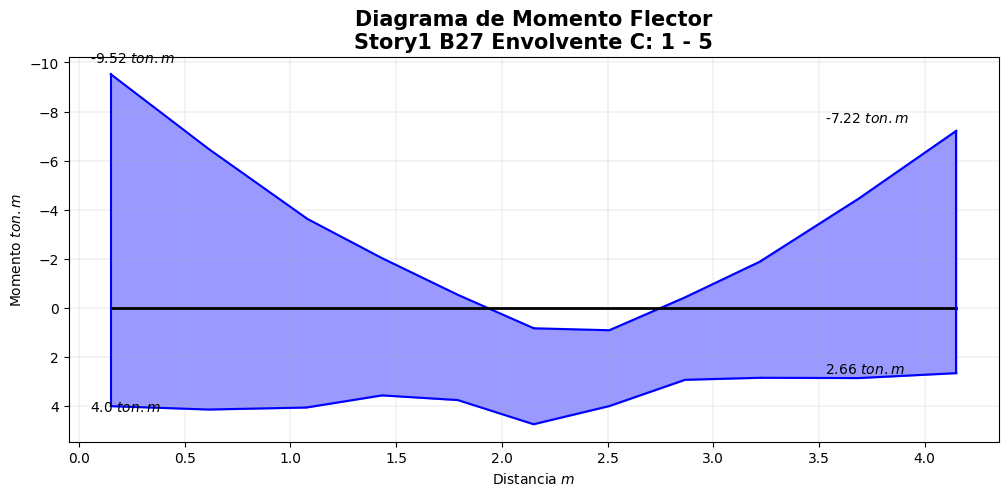

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(df1["Station"].values, df1["M3"].values, "b")        # plotear maximo
plt.plot(df2["Station"].values, df2["M3"].values, "b")        # plotear minimo
# plotear eje de la viga
plt.plot([df1.iloc[0, 7], L], [0, 0], "k", lw=2)
plt.plot([df1.iloc[0, 7], df1.iloc[0, 7]], [Mis, Mii], "b")
plt.plot([L, L], [Mds, Mdi], "b")
plt.title("Diagrama de Momento Flector"+"\n" +
          piso[0]+" "+nombre_viga[0]+" "+combinacion[0], fontsize=15, fontweight="bold")
plt.xlabel("Distancia $m$")
plt.ylabel("Momento $ton.m$")
# anotaciones
plt.annotate(str(round(Mis, 2))+" $ton.m$",
             xy=(0, Mis), xytext=(0.05, 1.05*Mis))
plt.annotate(str(round(Mds, 2))+" $ton.m$",
             xy=(L, 1.7*Mds), xytext=(0.85*L, Mds))
plt.annotate(str(round(Mii, 2))+" $ton.m$",
             xy=(0, Mii), xytext=(0.05, 1.05*Mii))
plt.annotate(str(round(Mdi, 2))+" $ton.m$",
             xy=(L, Mdi), xytext=(0.85*L, 1.05*Mdi))
plt.gca().invert_yaxis()
plt.grid(linestyle='-', linewidth=0.2)

# achurar area de la grafica
plt.fill_between(df1['Station'], df1['M3'], df2['M3'], color="blue", alpha=0.4)

plt.show()

obtener el Mu de diseño (el maximo momento del envolvente)


In [16]:
Mepos = df1["M3"].max()
Meneg = df2["M3"].min()

print("Mepos = ", Mepos)

print("Meneg = ", Meneg)

Mepos =  4.7386
Meneg =  -9.5208


### **DISEÑO POR FLEXION**


In [17]:
import modelviga as vp
from milca import vigas as vt

DATOS


In [18]:
b = 0.30    # m
h = 0.50    # m
r = 0.05    # m
fc = 210    # kg/cm2
fy = 4200   # kg/cm2

# escoger el mayor de los momentos
Mu = max(Mepos, abs(Meneg))
de = 0.0127  # m 1/2"
viga = vt.VigaR(Mu, b*100, h*100, r*100, fc, fy)

In [19]:
conj = viga.As()
Asmin = viga.Asmin()         # As minimo
Asc = conj["Asc = A\'s"]     # As de compresion
Ast = conj["Ast"]            # As de traccion
Asmax = viga.Asmax()        # As maximo

print(f"Asmin = {viga.Asmin():.2f}cm2   (Area de acero minimo)")
print(f"Ast = {Ast:.2f}cm2      (area de acero de traccion)")
print(f"A'c = {Asc:.2f}cm2      (area de acero de compresion)")
print(f"Asmax = {viga.Asmax():.2f}cm2   (Area de acero maximo)")

Asmin = 4.50cm2   (Area de acero minimo)
Ast = 5.90cm2      (area de acero de traccion)
A'c = 4.50cm2      (area de acero de compresion)
Asmax = 21.52cm2   (Area de acero maximo)


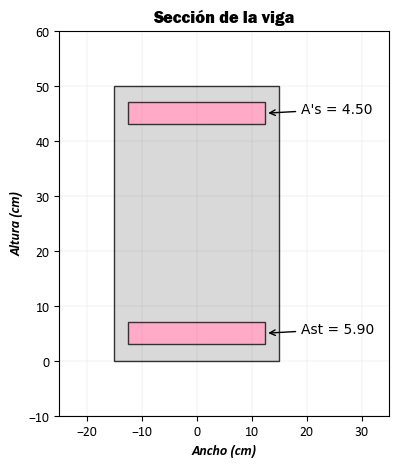

In [ ]:
viga.plot(K=5)

In [20]:
# Datos de la tabla completa
data = {
    'Diámetro #': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'Diámetro [Pulg]': ['1/4', '3/8', '1/2', '5/8', '3/4', '7/8', '1', '1 1/8', '1 1/4', '1 3/8'],
    'Diámetro [mm]': [6.4, 9.5, 12.7, 15.9, 19.1, 22.2, 25.4, 28.6, 31.8, 34.9],
    'Sección [cm2]': [0.317, 0.713, 1.267, 1.979, 2.850, 3.879, 5.067, 6.413, 7.917, 9.580],
    'Peso [Kg/m]': [0.249, 0.559, 0.994, 1.554, 2.237, 3.045, 3.978, 5.034, 6.255, 7.520]
}

# Crear el DataFrame completo
df_completo = pd.DataFrame(data)

# Reducir el DataFrame a las varillas recomendadas por el libro de Blanco para vigas
varillas_recomendadas = ['1/2', '5/8', '3/4', '7/8', '1']
df_vigas = df_completo[df_completo['Diámetro [Pulg]'].isin(
    varillas_recomendadas)].reset_index(drop=True)
df_vigas

,Diámetro #,Diámetro [Pulg],Diámetro [mm],Sección [cm2],Peso [Kg/m]
0,4,1/2,12.7,1.267,0.994
1,5,5/8,15.9,1.979,1.554
2,6,3/4,19.1,2.850,2.237
3,7,7/8,22.2,3.879,3.045
4,8,1,25.4,5.067,3.978


varillas longitudinales (ELECCION MANUAL)


In [21]:
acc = [3, 0.5*2.54/100, "1/2"]    # numero, diametro, "diametro"
att = [3, 5/8*2.54/100, "5/8"]    # numero, diametro, "diametro"

### **DISEÑO A CORTE**


#### **_EXTARACCION DE DATOS DE ETABS_**


In [24]:
Vis = float(df1.iloc[0, 9])
Vii = float(df2.iloc[0, 9])
Vds = float(df1.iloc[-1, 9])
Vdi = float(df2.iloc[-1, 9])
print("Vis = ", Vis)
print("Vii = ", Vii)
print("Vds = ", Vds)
print("Vdi = ", Vdi)

Vis =  -0.5353
Vii =  -10.9406
Vds =  10.3136
Vdi =  0.6697


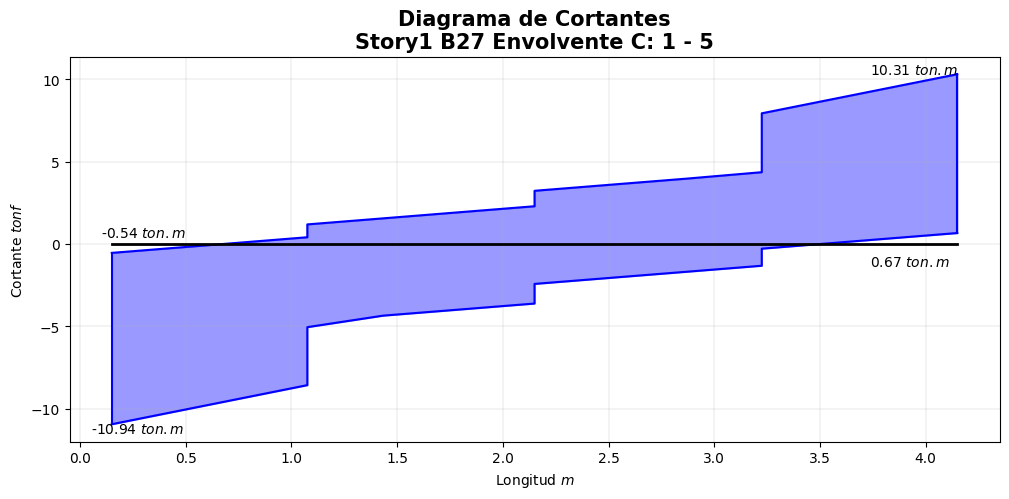

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(df1["Station"].values, np.array(
    pd.to_numeric(df1["V2"])), "b")  # plotear minimo
plt.plot(df2["Station"].values, np.array(
    pd.to_numeric(df2["V2"])), "b")  # plotear maximo
plt.plot([df1.iloc[0, 7], L], [0, 0], "k", lw=2)
plt.plot([df1.iloc[0, 7], df1.iloc[0, 7]], [Vii,  Vis], "b")
plt.plot([L, L], [Vdi, Vds], "b")
plt.title("Diagrama de Cortantes"+"\n" +
          piso[0]+" "+nombre_viga[0]+" "+combinacion[0], fontsize=15, fontweight="bold")
plt.xlabel("Longitud $m$")
plt.ylabel("Cortante $tonf$")
# anotaciones
plt.annotate(str(round(Vis, 2))+" $ton.m$",
             xy=(0, Vis), xytext=(0.1, 1 + 1.10*Vis))
plt.annotate(str(round(Vds, 2))+" $ton.m$",
             xy=(L, 1*Vds), xytext=(0.9*L, Vds))
plt.annotate(str(round(Vii, 2))+" $ton.m$",
             xy=(0, Vii), xytext=(0.05, 1.05*Vii))
plt.annotate(str(round(Vdi, 2))+" $ton.m$",
             xy=(L, 1*Vdi), xytext=(0.9*L, Vdi-2))
plt.grid(linestyle='-', linewidth=0.2)
plt.fill_between(df1['Station'], np.array(pd.to_numeric(df1["V2"])), np.array(
    pd.to_numeric(df2["V2"])), color="blue", alpha=0.4)

plt.show()

#### **obtension de cortante ultima y estribos**


In [56]:
Vumax = max(max(np.array(pd.to_numeric(df1["V2"]))), abs(
    min(np.array(pd.to_numeric(df2["V2"])))))
Vu = Vumax - 0.7*(h-r)
n = 2           # nuemero de ramas
SE = "Dual1"    # sistema estructural
zona_es_sismica = True
dt = att[1]     # m
tramos = vt.calcular_estribos(Vumax, b, h, r, L, fc, fy, de, dt, n, SE)
print(tramos)

[(1, 0.05), (10, 0.1), (10, 0.2)]


#### **ploteo**


In [57]:
##############################################################################
# varillas longitudinales
dc = acc[1]  # 1/2
nc = acc[0]
dt = att[1]  # 5/8
nt = att[0]

# estribos
ei = tramos[0][1]       # espaciamiento inicial
# primer espaciamiento de los estribos (generalmente 5cm)
e1 = tramos[0][1]
n1 = tramos[0][0]       # número de estribos con espaciamiento e1
e2 = tramos[1][1]       # segundo espaciamiento de los estribos
n2 = tramos[1][0]       # número de estribos con espaciamiento e2
e3 = tramos[2][1]       # tercer espaciamiento de los estribos (resto)

de_fracc = '1/2'
# Anotaciones de las barras longitudinales
dcp = acc[2]
dtp = att[2]
rr = r-dt / 2 - de
###############################################################################

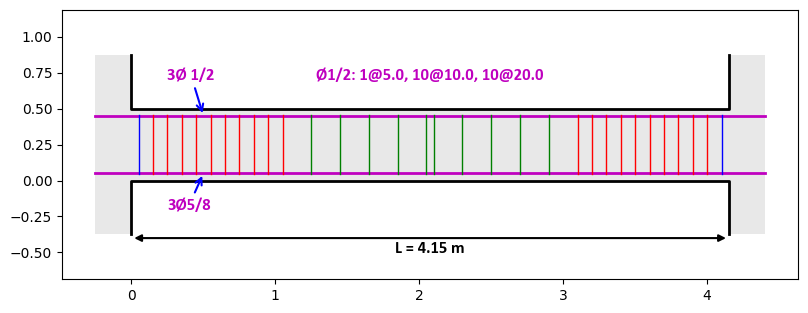

In [73]:
def estribos(L, h, rr, de, tramos):
    estribos_puntos = []
    # Lista de colores para los tramos
    colores = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    recubrimiento_lateral = de + rr

    x_actual = tramos[0][1]  # Empezar desde el espaciamiento del primer tramo

    for idx, tramo in enumerate(tramos):
        numero, espaciamiento = tramo
        for i in range(1, int(numero)+1):
            x1 = x_actual + i * espaciamiento - tramos[0][1]
            x2 = L - x1
            if x1 > x2:
                break
            p1 = (x1, recubrimiento_lateral)
            p2 = (x1, h - recubrimiento_lateral)
            estribos_puntos.append([p1, p2, colores[idx]])
            p1 = (x2, recubrimiento_lateral)
            p2 = (x2, h - recubrimiento_lateral)
            estribos_puntos.append([p1, p2, colores[idx]])
        x_actual += numero * espaciamiento

    return estribos_puntos


# Puntos de la geometría
V = 0.75
H = 0.50
pc1 = (-H * h, -V * h)
pc2 = (0, -V * h)
pc3 = (0, 0)
pc4 = (L, 0)
pc5 = (L, -V * h)
pc6 = (L + H * h, -V * h)
pc7 = (L + H * h, (1 + V) * h)
pc8 = (L, (1 + V) * h)
pc9 = (L, h)
pc10 = (0, h)
pc11 = (0, (1 + V) * h)
pc12 = (-H * h, (1 + V) * h)
region = [pc1, pc2, pc3, pc4, pc5, pc6, pc7, pc8, pc9, pc10, pc11, pc12]
borde_s = [pc8, pc9, pc10, pc11]
borde_i = [pc2, pc3, pc4, pc5]

# Aceros longitudinales
aceroSup = [(-H * h, h - r), (L + H * h, h - r)]
aceroInf = [(-H * h, r), (L + H * h, r)]

# estribos
estribos_puntos = estribos(L, h, rr, de, tramos)

# región
x, y = zip(*region)
plt.figure(figsize=((2 * H * h + L + 0.2 * h) * 2, (2 * V * h + h + h) * 2))
# 'b' es el color azul, y alpha es la transparencia
plt.fill(x, y, '#d3d3d3', edgecolor='none', alpha=0.5)

# borde
x, y = zip(*borde_s)
plt.plot(x, y, 'k', lw=2)
x, y = zip(*borde_i)
plt.plot(x, y, 'k', lw=2)
# Asegurar que los ejes X e Y tengan la misma escala
plt.axis('equal')

# aceros longitudinales
x, y = zip(*aceroSup)
plt.plot(x, y, 'm', lw=2)
x, y = zip(*aceroInf)
plt.plot(x, y, 'm', lw=2)

# estribos
for p1, p2, color in estribos_puntos:
    x, y = zip(*[p1, p2])
    plt.plot(x, y, color, lw=1)

plt.annotate(f'{nc}Ø {dcp}', xy=(1*h, h-r), xytext=(aceroSup[0][0] + 1*h, aceroSup[0][1] + 0.5*h),
             arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
             fontsize=12, fontweight='bold', color='m', fontname='Calibri')

plt.annotate(f'{nt}Ø{dtp}', xy=(1*h, r), xytext=(aceroInf[0][0] + 1*h, aceroInf[0][1] - 0.5*h),
             arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
             fontsize=12, fontweight='bold', color='m', fontname='Calibri')

# Anotación de distribución de estribos
tramos_info = ', '.join([f'{t[0]}@{t[1]*100}' for t in tramos])
plt.text(L/2, aceroSup[0][1] + 0.5*h, f'Ø{de_fracc}: {tramos_info}',
         fontsize=12, fontweight='bold', ha='center', color='m', fontname='Calibri')


# Anotación tipo AutoCAD para la longitud L
plt.annotate('', xy=(L, -0.80*h), xytext=(0, -0.8*h),
             arrowprops=dict(arrowstyle='<|-|>', lw=1.5, color='black'))
plt.text(L/2, -h, f'L = {L} m', fontsize=12, fontweight='bold',
         ha='center', color='black', fontname='Calibri')

# # Anotación tipo AutoCAD para el peralte h
# plt.annotate('', xy=(-0.05, h), xytext=(-0.05, 0),
#              arrowprops=dict(arrowstyle='<|-|>', lw=1.5, color='black'))
# plt.text(-0.1, h/2, f'h = {h} m', fontsize=12, fontweight='bold', va='center', color='black', fontname='Calibri', rotation=90)

# Mostrar el gráfico
plt.show()

#### **modelado**


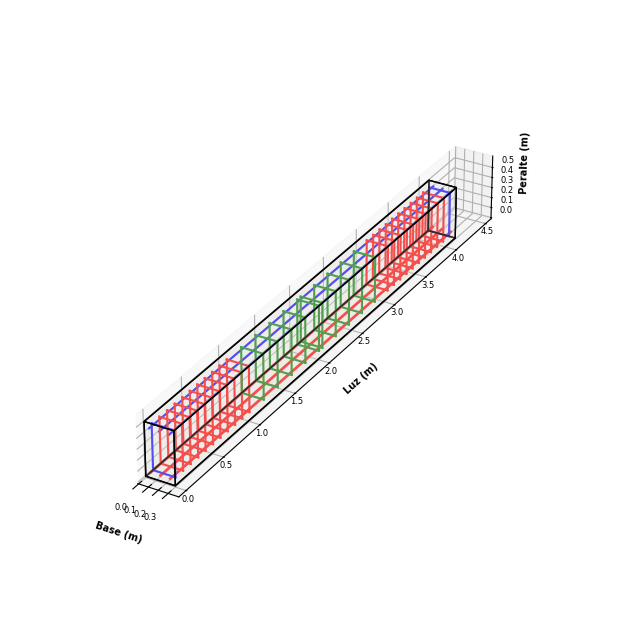

In [59]:
vp.modelar_viga(b, L, h, rr, dc, nc, dt, nt, de, ei,
                e1, n1, e2, n2, e3, rebarExtrude=False)

# **_las demas_**


In [60]:
# start_time = time.time()

# ton_m_C = 12
# ret = SapModel.SetPresentUnits(ton_m_C)

# table = SapModel.DatabaseTables.GetTableForDisplayArray(
#     "Element Forces - Beams", GroupName="")
# cols = table[2]
# noOfRows = table[3]
# vals = np.array_split(table[4], noOfRows)
# df = pd.DataFrame(vals)
# df.columns = cols

# piso = ["Story1"]
# nombre_viga = ["B74"]
# combinacion = ["Envolvente C: 1 - 5"]
# maximo = ["Max"]
# minimo = ["Min"]
# df = df[df.Story.isin(piso)]
# df = df[df.Beam.isin(nombre_viga)]
# df = df[df.OutputCase.isin(combinacion)]

# df["M3"] = df["M3"].astype(float)
# df["Station"] = df["Station"].astype(float)

# df1 = df[df.StepType.isin(maximo)]
# df2 = df[df.StepType.isin(minimo)]

# df1 = df1.sort_values(by=['Station'])

# end_time = time.time()
# elapsed_time = end_time - start_time
# print("Tiempo de ejecución: ", round(elapsed_time, 2), "segundos")


# Mis = df1.iloc[0, 14]

# Mii = df2.iloc[0, 14]

# Mds = df1.iloc[-1, 14]

# Mdi = df2.iloc[-1, 14]

# L = df2["Station"].max()
# print("Mis = ", Mis)
# print("Mii = ", Mii)
# print("Mds = ", Mds)
# print("Mdi = ", Mdi)

# print("L = ", L)


# plt.figure(figsize=(12, 5))

# plt.plot(df1["Station"].values, df1["M3"].values, "b")        # plotear maximo

# plt.plot(df2["Station"].values, df2["M3"].values, "b")        # plotear minimo

# # plotear eje de la viga

# plt.plot([df1.iloc[0, 7], L], [0, 0], "k", lw=2)

# plt.plot([df1.iloc[0, 7], df1.iloc[0, 7]], [Mis, Mii], "b")

# plt.plot([L, L], [Mds, Mdi], "b")

# plt.title("Diagrama de Momento Flector"+"\n" +

#           piso[0]+" "+nombre_viga[0]+" "+combinacion[0], fontsize=15, fontweight="bold")

# plt.xlabel("Distancia $m$")

# plt.ylabel("Momento $ton.m$")

# # anotaciones

# plt.annotate(str(round(Mis, 2))+" $ton.m$",

#              xy=(0.1, Mis), xytext=(0.20, 1.10*Mis))

# plt.annotate(str(round(Mds, 2))+" $ton.m$",

#              xy=(L, 1.5*Mds), xytext=(0.9*L, Mds))

# plt.annotate(str(round(Mii, 2))+" $ton.m$",

#              xy=(0, Mii), xytext=(0.05, 1.05*Mii))

# plt.annotate(str(round(Mdi, 2))+" $ton.m$",

#              xy=(L, 1.1*Mdi), xytext=(0.85*L, 1.05*Mdi))

# plt.gca().invert_yaxis()

# plt.grid(linestyle='-', linewidth=0.2)


# # achurar area de la grafica

# plt.fill_between(df1['Station'], df1['M3'], df2['M3'], color="blue", alpha=0.4)


# plt.show()

In [61]:
# Mepos = df1["M3"].max()
# Meneg = df2["M3"].min()
# print("Mepos = ", Mepos)
# print("Meneg = ", Meneg)

### **DISEÑO POR FLEXION**


In [62]:
# b = 0.30    # m
# h = 0.50    # m
# r = 0.05    # m
# fc = 210    # kg/cm2
# fy = 4200   # kg/cm2
# d = h - r
# # escoger el mayor de los momentos
# Mu = max(Mepos, abs(Meneg))
# de = 0.0127  # m
# rr = r - de/2
# viga = vt.VigaR(Mu, b*100, h*100, r*100, fc, fy)
# conj = viga.As()
# Asc = conj["Asc = A\'s"]  # As de compresion
# Ast = conj["Ast"]            # As de traccion

# print(f"Asmin = {viga.Asmin():.2f}cm2")
# print(f"Ast = {Ast:.2f}cm2")
# print(f"A'c = {Asc:.2f}cm2")
# print(f"Asmax = {viga.Asmax():.2f}cm2")
# viga.plot(K=5)

In [63]:
# # escoger el mayor de los momentos
# Mu = max(Mepos, abs(Meneg))

# # varillas longitudinales
# dc = 0.0127  # 1/2
# nc = 3
# dt = 0.0159  # 5/8
# nt = 2

# # estribos
# ei = 0.05       # espaciamiento inicial
# e1 = 0.05       # primer espaciamiento de los estribos (generalmente 5cm)
# n1 = 1.00       # número de estribos con espaciamiento e1
# e2 = 0.10       # segundo espaciamiento de los estribos
# n2 = 4.00       # número de estribos con espaciamiento e2
# e3 = 0.20       # tercer espaciamiento de los estribos (resto)

# rr = (r-de/2)

# vp.modelar_viga(b, L, h, rr, dc, nc, dt, nt, de, ei,
#                 e1, n1, e2, n2, e3, rebarExtrude=False)

### **VIGA CON ESTRIBOS**


In [64]:
# # Estribos
# tramos = [
#     (0.05, 1),  # (espaciamiento, número de estribos)
#     (0.10, 4),
#     (0.25, 100)
# ]

# de_fracc = '1/2'
# # Anotaciones de las barras longitudinales
# dcp = "1/2"
# dtp = "5/8"

In [65]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# ##############################################################################

# # Estribos
# de = 0.0127     # diámetro de los estribos
# tramos = [
#     (0.05, 1),  # (espaciamiento, número de estribos)
#     (0.10, 4),
#     (0.25, 100)
# ]

# de_fracc = '1/2'
# # Anotaciones de las barras longitudinales
# dcp = "1/2"
# dtp = "1/2"

# ###############################################################################


# def estribos(L, h, rr, de, tramos):
#     estribos_puntos = []
#     # Lista de colores para los tramos
#     colores = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
#     recubrimiento_lateral = de + rr

#     x_actual = tramos[0][0]  # Empezar desde el espaciamiento del primer tramo

#     for idx, tramo in enumerate(tramos):
#         espaciamiento, numero = tramo
#         for i in range(1, int(numero)+1):
#             x1 = x_actual + i * espaciamiento - tramos[0][0]
#             x2 = L - x1
#             if x1 > x2:
#                 break
#             p1 = (x1, recubrimiento_lateral)
#             p2 = (x1, h - recubrimiento_lateral)
#             estribos_puntos.append([p1, p2, colores[idx]])
#             p1 = (x2, recubrimiento_lateral)
#             p2 = (x2, h - recubrimiento_lateral)
#             estribos_puntos.append([p1, p2, colores[idx]])
#         x_actual += numero * espaciamiento

#     return estribos_puntos


# r = dt / 2 + de + rr

# # Puntos de la geometría
# V = 0.75
# H = 0.50
# pc1 = (-H * h, -V * h)
# pc2 = (0, -V * h)
# pc3 = (0, 0)
# pc4 = (L, 0)
# pc5 = (L, -V * h)
# pc6 = (L + H * h, -V * h)
# pc7 = (L + H * h, (1 + V) * h)
# pc8 = (L, (1 + V) * h)
# pc9 = (L, h)
# pc10 = (0, h)
# pc11 = (0, (1 + V) * h)
# pc12 = (-H * h, (1 + V) * h)
# region = [pc1, pc2, pc3, pc4, pc5, pc6, pc7, pc8, pc9, pc10, pc11, pc12]
# borde_s = [pc8, pc9, pc10, pc11]
# borde_i = [pc2, pc3, pc4, pc5]

# # Aceros longitudinales
# aceroSup = [(-H * h, h - r), (L + H * h, h - r)]
# aceroInf = [(-H * h, r), (L + H * h, r)]

# # estribos
# estribos_puntos = estribos(L, h, rr, de, tramos)

# # región
# x, y = zip(*region)
# plt.figure(figsize=((2 * H * h + L + 0.2 * h) * 2, (2 * V * h + h + h) * 2))
# # 'b' es el color azul, y alpha es la transparencia
# plt.fill(x, y, '#d3d3d3', edgecolor='none', alpha=0.5)

# # borde
# x, y = zip(*borde_s)
# plt.plot(x, y, 'k', lw=2)
# x, y = zip(*borde_i)
# plt.plot(x, y, 'k', lw=2)
# # Asegurar que los ejes X e Y tengan la misma escala
# plt.axis('equal')

# # aceros longitudinales
# x, y = zip(*aceroSup)
# plt.plot(x, y, 'm', lw=2)
# x, y = zip(*aceroInf)
# plt.plot(x, y, 'm', lw=2)

# # estribos
# for p1, p2, color in estribos_puntos:
#     x, y = zip(*[p1, p2])
#     plt.plot(x, y, color, lw=1)


# plt.annotate(f'{nc}Ø {dcp}', xy=(1*h, h-r), xytext=(aceroSup[0][0] + 1*h, aceroSup[0][1] + 0.5*h),
#              arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
#              fontsize=12, fontweight='bold', color='m', fontname='Calibri')

# plt.annotate(f'{nt}Ø{dtp}', xy=(1*h, r), xytext=(aceroInf[0][0] + 1*h, aceroInf[0][1] - 0.5*h),
#              arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
#              fontsize=12, fontweight='bold', color='m', fontname='Calibri')

# # Anotación de distribución de estribos
# tramos_info = ', '.join([f'{t[1]}@{t[0]}' for t in tramos])
# plt.text(L/2, aceroSup[0][1] + 0.5*h, f'Ø{de_fracc}: {tramos_info}',
#          fontsize=12, fontweight='bold', ha='center', color='m', fontname='Calibri')


# # Anotación tipo AutoCAD para la longitud L
# plt.annotate('', xy=(L, -0.80*h), xytext=(0, -0.8*h),
#              arrowprops=dict(arrowstyle='<|-|>', lw=1.5, color='black'))
# plt.text(L/2, -h, f'L = {L} m', fontsize=12, fontweight='bold',
#          ha='center', color='black', fontname='Calibri')

# # # Anotación tipo AutoCAD para el peralte h
# # plt.annotate('', xy=(-0.05, h), xytext=(-0.05, 0),
# #              arrowprops=dict(arrowstyle='<|-|>', lw=1.5, color='black'))
# # plt.text(-0.1, h/2, f'h = {h} m', fontsize=12, fontweight='bold', va='center', color='black', fontname='Calibri', rotation=90)

# # Mostrar el gráfico
# plt.show()

In [66]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# ##############################################################################

# # Estribos
# de = 0.0127     # diámetro de los estribos
# tramos = [
#     (5, 0.1),  # (número de estribos, espaciamiento)
#     (4, 0.10),
#     (100, 0.25)
# ]

# de_fracc = '1/2'
# # Anotaciones de las barras longitudinales
# dcp = "1/2"
# dtp = "1/2"

# ###############################################################################


# def estribos(L, h, rr, de, tramos):
#     estribos_puntos = []
#     # Lista de colores para los tramos
#     colores = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
#     recubrimiento_lateral = de + rr

#     x_actual = tramos[0][1]  # Empezar desde el espaciamiento del primer tramo

#     for idx, tramo in enumerate(tramos):
#         numero, espaciamiento = tramo
#         for i in range(1, int(numero)+1):
#             x1 = x_actual + i * espaciamiento - tramos[0][1]
#             x2 = L - x1
#             if x1 > x2:
#                 break
#             p1 = (x1, recubrimiento_lateral)
#             p2 = (x1, h - recubrimiento_lateral)
#             estribos_puntos.append([p1, p2, colores[idx]])
#             p1 = (x2, recubrimiento_lateral)
#             p2 = (x2, h - recubrimiento_lateral)
#             estribos_puntos.append([p1, p2, colores[idx]])
#         x_actual += numero * espaciamiento

#     return estribos_puntos


# r = dt / 2 + de + rr

# # Puntos de la geometría
# V = 0.75
# H = 0.50
# pc1 = (-H * h, -V * h)
# pc2 = (0, -V * h)
# pc3 = (0, 0)
# pc4 = (L, 0)
# pc5 = (L, -V * h)
# pc6 = (L + H * h, -V * h)
# pc7 = (L + H * h, (1 + V) * h)
# pc8 = (L, (1 + V) * h)
# pc9 = (L, h)
# pc10 = (0, h)
# pc11 = (0, (1 + V) * h)
# pc12 = (-H * h, (1 + V) * h)
# region = [pc1, pc2, pc3, pc4, pc5, pc6, pc7, pc8, pc9, pc10, pc11, pc12]
# borde_s = [pc8, pc9, pc10, pc11]
# borde_i = [pc2, pc3, pc4, pc5]

# # Aceros longitudinales
# aceroSup = [(-H * h, h - r), (L + H * h, h - r)]
# aceroInf = [(-H * h, r), (L + H * h, r)]

# # estribos
# estribos_puntos = estribos(L, h, rr, de, tramos)

# # región
# x, y = zip(*region)
# plt.figure(figsize=((2 * H * h + L + 0.2 * h) * 2, (2 * V * h + h + h) * 2))
# # 'b' es el color azul, y alpha es la transparencia
# plt.fill(x, y, '#d3d3d3', edgecolor='none', alpha=0.5)

# # borde
# x, y = zip(*borde_s)
# plt.plot(x, y, 'k', lw=2)
# x, y = zip(*borde_i)
# plt.plot(x, y, 'k', lw=2)
# # Asegurar que los ejes X e Y tengan la misma escala
# plt.axis('equal')

# # aceros longitudinales
# x, y = zip(*aceroSup)
# plt.plot(x, y, 'm', lw=2)
# x, y = zip(*aceroInf)
# plt.plot(x, y, 'm', lw=2)

# # estribos
# for p1, p2, color in estribos_puntos:
#     x, y = zip(*[p1, p2])
#     plt.plot(x, y, color, lw=1)

# plt.annotate(f'{nc}Ø {dcp}', xy=(1*h, h-r), xytext=(aceroSup[0][0] + 1*h, aceroSup[0][1] + 0.5*h),
#              arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
#              fontsize=12, fontweight='bold', color='m', fontname='Calibri')

# plt.annotate(f'{nt}Ø{dtp}', xy=(1*h, r), xytext=(aceroInf[0][0] + 1*h, aceroInf[0][1] - 0.5*h),
#              arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
#              fontsize=12, fontweight='bold', color='m', fontname='Calibri')

# # Anotación de distribución de estribos
# tramos_info = ', '.join([f'{t[0]}@{t[1]}' for t in tramos])
# plt.text(L/2, aceroSup[0][1] + 0.5*h, f'Ø{de_fracc}: {tramos_info}',
#          fontsize=12, fontweight='bold', ha='center', color='m', fontname='Calibri')


# # Anotación tipo AutoCAD para la longitud L
# plt.annotate('', xy=(L, -0.80*h), xytext=(0, -0.8*h),
#              arrowprops=dict(arrowstyle='<|-|>', lw=1.5, color='black'))
# plt.text(L/2, -h, f'L = {L} m', fontsize=12, fontweight='bold',
#          ha='center', color='black', fontname='Calibri')

# # # Anotación tipo AutoCAD para el peralte h
# # plt.annotate('', xy=(-0.05, h), xytext=(-0.05, 0),
# #              arrowprops=dict(arrowstyle='<|-|>', lw=1.5, color='black'))
# # plt.text(-0.1, h/2, f'h = {h} m', fontsize=12, fontweight='bold', va='center', color='black', fontname='Calibri', rotation=90)

# # Mostrar el gráfico
# plt.show()

### **_DISEÑO POR CORTE_**


### **_EXTARACCION DE DATOS DE ETABS_**


In [67]:
# Vis = df1.iloc[0, 11]
# Vii = df2.iloc[0, 11]
# Vds = df1.iloc[-1, 11]
# Vdi = df2.iloc[-1, 11]
# L = df2["Station"].max()
# print("Vis = ", Mis)
# print("Vii = ", Mii)
# print("Vds = ", Mds)
# print("Vdi = ", Mdi)
# print("L = ", L)

In [68]:
# plt.figure(figsize=(12, 5))
# plt.plot(df2["Station"].values, df2["V2"].values, "b")        # plotear minimo
# plt.plot(df1["Station"].values, df1["V2"].values, "b")        # plotear maximo
# # plotear eje de la viga
# plt.plot([df1.iloc[0, 8], L], [0, 0], "k", lw=2)
# plt.plot([df1.iloc[0, 8], df1.iloc[0, 8]], [Vis, Vii], "b")
# plt.plot([L, L], [Vdi, Vds], "b")
# plt.title("Diagrama de Cortantes"+"\n" +
#           piso[0]+" "+nombre_viga[0]+" "+combinacion[0], fontsize=15, fontweight="bold")
# plt.xlabel("cortante $m$")
# plt.ylabel("Momento $tonf$")
# # # anotaciones
# # plt.annotate(str(round(Vis, 2))+" $ton.m$",
# #              xy=(0.1, Vis), xytext=(0.20, 1.10*Vis))
# # plt.annotate(str(round(Vds, 2))+" $ton.m$",
# #              xy=(L, 1.5*Vds), xytext=(0.9*L, Vds))
# # plt.annotate(str(round(Vii, 2))+" $ton.m$",
# #              xy=(0, Vii), xytext=(0.05, 1.05*Vii))
# # plt.annotate(str(round(Vdi, 2))+" $ton.m$",
# #              xy=(L, 1.1*Vdi), xytext=(0.85*L, 1.05*Vdi))
# # # plt.gca().invert_yaxis()
# plt.grid(linestyle='-', linewidth=0.2)

# # # achurar area de la grafica
# plt.fill_between(df1['Station'], df1['V2'], df2['V2'], color="blue", alpha=0.4)

# plt.show()

In [69]:
# # DATOS
# from math import sqrt
# Vumax = 17.27    # ton
# Øcorte = 0.85
# b = 0.30    # m
# h = 0.70    # m
# r = 0.06    # m
# fc = 210    # kg/cm2
# fy = 4200   # kg/cm2
# de = 0.0095  # m
# n = 2       # nuemero de ramas

# SE = "Dual2"    # *Dual1, Dual2*tipo de sistema estructural
# dt = 0.0159  # m

# zona_es_sismica = True

# tramos = vt.calcular_estribos(Vumax, b, h, r, L, fc, fy, de, dt, n, SE)
# print(tramos)